To begin the exercise, I import my most important libraries and do some basic data exploration.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
cust = pd.read_csv('180601_Customer_Info.csv')
cust.head()

,customer_id,sign_up_date,sign_up_channel
0,2543,2021-04-26,Price Comparison Website
1,2181,2021-07-24,Referral
2,2399,2020-10-11,Bulb Website
3,674,2021-04-04,Referral
4,2332,2021-09-05,Price Comparison Website


In [3]:
cust.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 3 columns):
customer_id        1699 non-null int64
sign_up_date       1699 non-null object
sign_up_channel    1699 non-null object
dtypes: int64(1), object(2)
memory usage: 39.9+ KB


In [4]:
print(cust.duplicated().sum())
print(cust['customer_id'].duplicated().sum())
#one customer ID duplicate. lets investigate it


0
1


In [5]:
#investigate the duplicate
cust[cust['customer_id'].duplicated(keep='first')]
#let's see if this cutomer_id has been in the list of referrers

,customer_id,sign_up_date,sign_up_channel
1380,116,2020-10-27,Bulb Website


In [6]:
ref = pd.read_csv('180601_Referrals_Info.csv')
ref.head()


,referral_date,referrer_customer_id,sign_up_customer_id
0,2021-07-18,795,1771
1,2021-04-12,577,1510
2,2021-07-07,868,1858
3,2021-10-25,801,1778
4,2021-08-15,690,1637


In [7]:
ref.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
referral_date           1000 non-null object
referrer_customer_id    1000 non-null int64
sign_up_customer_id     1000 non-null int64
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [8]:
print(ref.duplicated(keep='first').sum())
print(ref['referrer_customer_id'].duplicated(keep='first').sum())
#there are cutomers who referred multiple new customers

0
131


Quick test to see if the 'sign_up_customer_id' in ref is a new cutomer that used the referral code

In [9]:
#view a random custome_id in the cust set 
cust[cust['customer_id'] ==163]


,customer_id,sign_up_date,sign_up_channel
584,163,2021-07-26,Referral


In [10]:
#see if the same ID appears under the referrer_customer_id (or the sign_up_customer_id)
ref[ref['referrer_customer_id'] ==163]


,referral_date,referrer_customer_id,sign_up_customer_id
852,2021-09-25,163,1039


In [11]:
#and does not appear under signed up customer ID, 
#which means that signed_customer_ID is the the ID of a new customer
#added due to the referral
ref[ref['sign_up_customer_id'] ==163]


,referral_date,referrer_customer_id,sign_up_customer_id


Investigate how many customers did not refer (customer_id in cust is not found in referrer_customer_id in ref), and whether there are any customers who have referred, but do not appear in the main dataset (referrer_customer_id exists in ref, but does not exist as customer_id in cust)

In [12]:
not_ref = cust[~cust['customer_id'].isin(ref ['referrer_customer_id'])]
not_cust = ref[~ref['referrer_customer_id'].isin(cust['customer_id'])]

print('Number of customer IDs absent from the referals (ref) dataset: ', not_ref.shape[0])
print('Number of referrer customer IDs absent from the main customer (cust) dataset: ', not_cust.shape[0])


Number of customer IDs absent from the referals (ref) dataset:  997
Number of referrer customer IDs absent from the main customer (cust) dataset:  170


Investigate custmer_ID 116 and decide what to do with it.

In [13]:
#check if the duplicate id in cust dataset appears in ref dataset
ref[ref['referrer_customer_id'] ==116]
#since it does, and it is only one case, 
#I will remove this customer ID for the sake of the analysis

,referral_date,referrer_customer_id,sign_up_customer_id
273,2021-05-16,116,990
879,2021-05-08,116,1304


Remove the duplicate ID from both datasets

In [14]:
cust = cust.drop_duplicates('customer_id', keep=False)
ref = ref[ref.referrer_customer_id != 116]

cust[cust['customer_id'] ==116]

,customer_id,sign_up_date,sign_up_channel


In [15]:
ref[ref['referrer_customer_id'] ==116]


,referral_date,referrer_customer_id,sign_up_customer_id


In [16]:
ref['referrer_customer_id'].duplicated().sum()

130

**The minimal exploratory data analysis focused on basic familiarization with the dataset:**
 - I looked at the general size of datasets and looked at the types of data at my disposal,
 - I investigated the duplicates,
 - I answered own questions about the values of some columns,
 - I made a decision how to deal with duplicates.

# 0. Feature engineering

In [26]:
cust['year'] = pd.to_datetime(cust['sign_up_date']).dt.year
cust['month'] = pd.to_datetime(cust['sign_up_date']).dt.month
cust['day'] = pd.to_datetime(cust['sign_up_date']).dt.day
cust['sign_up_date'] = pd.to_datetime(cust['sign_up_date'])
cust.head(10)

,customer_id,sign_up_date,sign_up_channel,year,month,day
0,2543,2021-04-26,Price Comparison Website,2021,4,26
1,2181,2021-07-24,Referral,2021,7,24
2,2399,2020-10-11,Bulb Website,2020,10,11
3,674,2021-04-04,Referral,2021,4,4
4,2332,2021-09-05,Price Comparison Website,2021,9,5
5,1893,2021-03-14,Price Comparison Website,2021,3,14
6,468,2021-06-10,Referral,2021,6,10
7,2638,2021-12-24,Price Comparison Website,2021,12,24
8,2110,2021-12-20,Price Comparison Website,2021,12,20
9,2616,2021-09-29,Referral,2021,9,29


In [27]:
ref['year'] = pd.to_datetime(ref['referral_date']).dt.year
ref['month'] = pd.to_datetime(ref['referral_date']).dt.month
ref['day'] = pd.to_datetime(ref['referral_date']).dt.day
ref['referral_date'] = pd.to_datetime(ref['referral_date'])
ref.head()

,referral_date,referrer_customer_id,sign_up_customer_id,year,month,day
484,2021-05-29,0,869,2021,5,29
323,2021-12-23,1,870,2021,12,23
246,2021-04-10,2,871,2021,4,10
10,2021-12-30,3,872,2021,12,30
76,2021-08-16,4,873,2021,8,16


# 1. When do members refer?

Investigate how long in their tenure customers make their first referal and how many referrals they make.

### 1.1 Prep data

1. Merge customer database with the referal database. On first referrals only (dataset - strat_1)
2. Engineer a time_elapsed variable - time elapsed from sign up up to first referral.
3. Create time bins - 30 days into customer tenure, 30< and <60 days into tenure, etc.

In [28]:
ref = ref.sort_values(['referrer_customer_id','referral_date'])
print('Original referral dataset shape: ', ref.shape)

first_ref = ref.drop_duplicates('referrer_customer_id', keep='first', inplace=False)
print('Only first referral dataset shape: ', first_ref.shape)

Original referral dataset shape:  (998, 6)
Only first referral dataset shape:  (868, 6)


In [29]:
strat_1 = pd.merge(cust, first_ref, left_on='customer_id', how='left', right_on='referrer_customer_id',
                  suffixes=('_cust', '_ref'), indicator=True)
strat_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697 entries, 0 to 1696
Data columns (total 13 columns):
customer_id             1697 non-null int64
sign_up_date            1697 non-null datetime64[ns]
sign_up_channel         1697 non-null object
year_cust               1697 non-null int64
month_cust              1697 non-null int64
day_cust                1697 non-null int64
referral_date           700 non-null datetime64[ns]
referrer_customer_id    700 non-null float64
sign_up_customer_id     700 non-null float64
year_ref                700 non-null float64
month_ref               700 non-null float64
day_ref                 700 non-null float64
_merge                  1697 non-null category
dtypes: category(1), datetime64[ns](2), float64(5), int64(4), object(1)
memory usage: 174.1+ KB


In [30]:
print('997 customers did not refer')
strat_1['_merge'].value_counts()

997 customers did not refer


left_only     997
both          700
right_only      0
Name: _merge, dtype: int64

In [31]:
strat_1['time_elapsed'] = np.where(strat_1['_merge']=='both', 
                                  (strat_1['referral_date']-strat_1['sign_up_date']).dt.days, np.NaN)

In [32]:
print('Bins: <30 days, 30< & <60 days, <60 & <100 days, <100 & <200 days, <200 & <300 days, <300 & <400 days, <400 & <500 days and >500 days')

days = ['<30 days', '<60 days', '<100 days', '<200 days', '<300 days', '<400 days', '<500 days', '>500 days']

strat_1['time_elapsed_m'] = pd.cut(x=strat_1['time_elapsed'], bins=[-1, 29, 69, 
                                                                      99, 199, 299, 
                                                                      399, 499, 
                                                                      strat_1['time_elapsed'].max()], labels=days)

strat_1['time_elapsed_m'] = np.where(strat_1['time_elapsed_m'].isnull()==True, 'No referral', strat_1['time_elapsed_m'])

Bins: <30 days, 30< & <60 days, <60 & <100 days, <100 & <200 days, <200 & <300 days, <300 & <400 days, <400 & <500 days and >500 days


### 1.2 Analysis

Text(0.5, 0, 'First referal in')

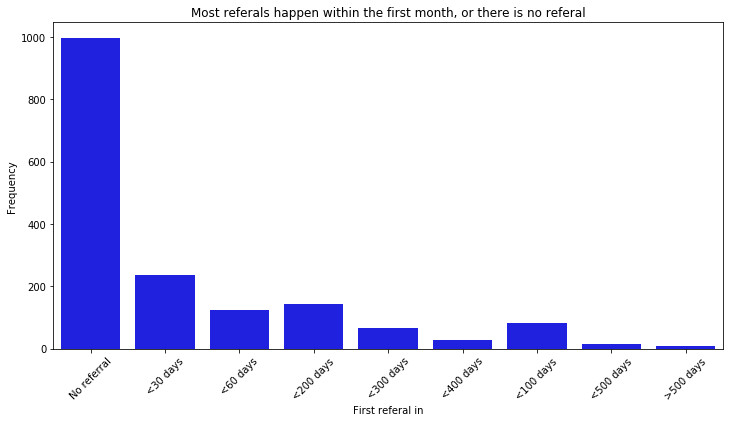

In [33]:
plt.figure(figsize=(12,6))
sb.countplot(data=strat_1, x='time_elapsed_m', color='blue')
plt.xticks(rotation=45)
plt.title("Most referals happen within the first month, or there is no referal")
plt.ylabel('Frequency')
plt.xlabel('First referal in')

### 1.3 How many times customers make a referal.

1. Merge customer database with the referal database. (dataset - strat_2)
2. Engineer a referral variable - a dummy variable that for each case marks 1 if customer referred and 0 if not.
3. Collapse strat_2 by customer ID to calculate how many times customer i referred.

In [64]:
strat_2 = pd.merge(cust, ref, left_on='customer_id', how='left', right_on='referrer_customer_id',
                  suffixes=('_cust', '_ref'), indicator=True)
strat_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1824
Data columns (total 13 columns):
customer_id             1825 non-null int64
sign_up_date            1825 non-null datetime64[ns]
sign_up_channel         1825 non-null object
year_cust               1825 non-null int64
month_cust              1825 non-null int64
day_cust                1825 non-null int64
referral_date           828 non-null datetime64[ns]
referrer_customer_id    828 non-null float64
sign_up_customer_id     828 non-null float64
year_ref                828 non-null float64
month_ref               828 non-null float64
day_ref                 828 non-null float64
_merge                  1825 non-null category
dtypes: category(1), datetime64[ns](2), float64(5), int64(4), object(1)
memory usage: 187.2+ KB


In [65]:
#vdummy for referal
strat_2['referral'] = np.where(strat_2['_merge']=='left_only', 0, 1)

In [66]:
#create an overall tenure variable
import datetime
strat_2['now'] = datetime.datetime(2022,2,3,0,0,0)

strat_2['tenure'] = (strat_2['now']-strat_2['sign_up_date']).dt.days

strat_2['tenure_m'] = pd.cut(x=strat_2['tenure'], bins=[-1, 29, 69, 99, 199, 299, 399, 499, 
                                                                      strat_2['tenure'].max()], labels=days)

In [67]:
#create a count of referrals variable 
strat_2['times_referred'] = strat_2.groupby(by='customer_id')['referral'].transform('sum')

In [68]:
strat_2['referral'].value_counts()

0    997
1    828
Name: referral, dtype: int64

In [69]:
table = pd.DataFrame(strat_2.groupby(by='customer_id')['referral'].sum().value_counts())

### 1.4 Analysis of referral count

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


Text(0.5, 1.0, 'How many times all customers have refered')

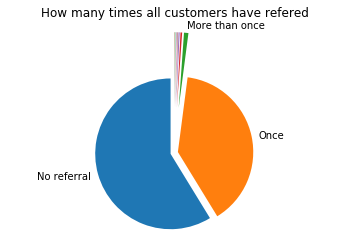

In [40]:
figure, axes = plt.subplots()
three_lab = ("No referral", "Once", "More than once", "", "", "", "", "", "", "", "", "")
explodeTuple = (0.05, 0.05, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6)

axes.pie(table, labels=three_lab, startangle=90, explode=explodeTuple)
axes.axis('equal')
plt.title('How many times all customers have refered')

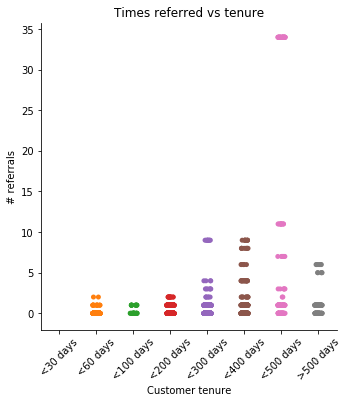

In [86]:
sb.catplot(data=strat_2, x='tenure_m', y='times_referred')
plt.title('Times referred vs tenure')
plt.xlabel('Customer tenure')
plt.ylabel('# referrals')
plt.xticks(rotation=45)
plt.show()

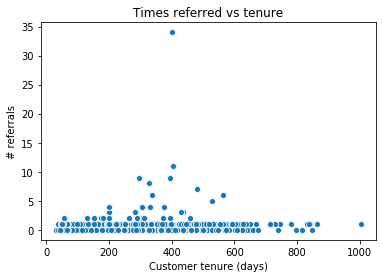

In [89]:
sb.scatterplot(data=strat_2, x='tenure', y='times_referred')
plt.title('Times referred vs tenure')
plt.xlabel('Customer tenure (days)')
plt.ylabel('# referrals')
plt.show()

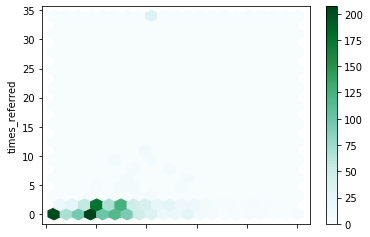

In [96]:
strat_2.plot(kind='hexbin', x='tenure', y='times_referred', gridsize=20)

# 2. Sign-up channel and referral behavior

Compare customers by sign-up channel.

1. First referral behavior by sign-up channel
2. Number of referrals by sign-up channel

### 2.1 Data prep


In [99]:
strat_1

,customer_id,sign_up_date,sign_up_channel,year_cust,month_cust,day_cust,referral_date,referrer_customer_id,sign_up_customer_id,year_ref,month_ref,day_ref,_merge,time_elapsed,time_elapsed_m
0,2543,2021-04-26,Price Comparison Website,2021,4,26,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
1,2181,2021-07-24,Referral,2021,7,24,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
2,2399,2020-10-11,Bulb Website,2020,10,11,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
3,674,2021-04-04,Referral,2021,4,4,2021-04-04,674.0,1618.0,2021.0,4.0,4.0,both,0.0,<30 days
4,2332,2021-09-05,Price Comparison Website,2021,9,5,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,820,2021-07-17,Referral,2021,7,17,2021-09-05,820.0,1802.0,2021.0,9.0,5.0,both,50.0,<60 days
1693,1945,2020-12-20,Price Comparison Website,2020,12,20,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
1694,2132,2021-11-29,Bulb Website,2021,11,29,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral
1695,2228,2021-10-11,Referral,2021,10,11,NaT,NaN,NaN,NaN,NaN,NaN,left_only,NaN,No referral


### 2.2 Analysis

In [144]:
strat_2

,customer_id,sign_up_date,sign_up_channel,year_cust,month_cust,day_cust,referral_date,referrer_customer_id,sign_up_customer_id,year_ref,month_ref,day_ref,_merge,referral,now,tenure,tenure_m,times_referred
0,2543,2021-04-26,Price Comparison Website,2021,4,26,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,283,<300 days,0
1,2181,2021-07-24,Referral,2021,7,24,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,194,<200 days,0
2,2399,2020-10-11,Bulb Website,2020,10,11,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,480,<500 days,0
3,674,2021-04-04,Referral,2021,4,4,2021-04-04,674.0,1618.0,2021.0,4.0,4.0,both,1,2022-02-03,305,<400 days,1
4,2332,2021-09-05,Price Comparison Website,2021,9,5,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,151,<200 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,820,2021-07-17,Referral,2021,7,17,2021-09-05,820.0,1802.0,2021.0,9.0,5.0,both,1,2022-02-03,201,<300 days,1
1821,1945,2020-12-20,Price Comparison Website,2020,12,20,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,410,<500 days,0
1822,2132,2021-11-29,Bulb Website,2021,11,29,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,66,<60 days,0
1823,2228,2021-10-11,Referral,2021,10,11,NaT,NaN,NaN,NaN,NaN,NaN,left_only,0,2022-02-03,115,<200 days,0


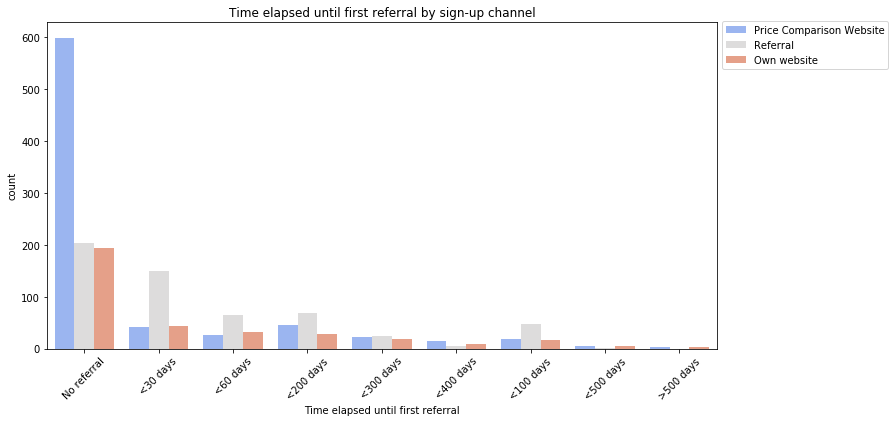

In [130]:
plt.figure(figsize=(12,6))
sb.countplot(data=strat_1, x='time_elapsed_m', hue='sign_up_channel', palette='coolwarm')

lab = ("Price Comparison Website", "Referral", "Own website")
plt.legend(labels=lab, bbox_to_anchor=(1, 1.02))
plt.xticks(rotation=45)
plt.xlabel('Time elapsed until first referral')
plt.title('Time elapsed until first referral by sign-up channel')
plt.show()

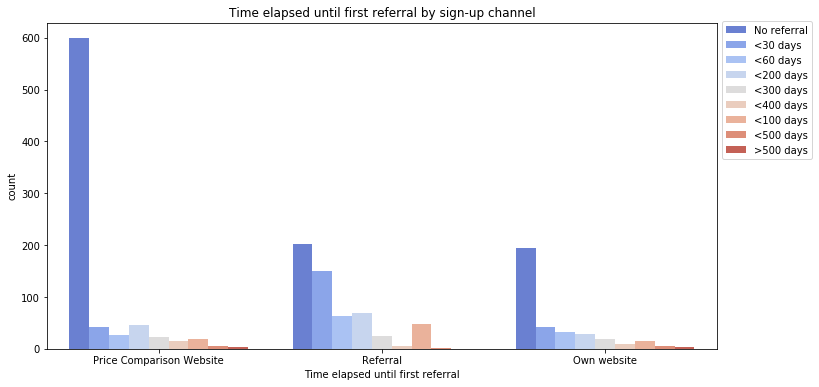

In [139]:
plt.figure(figsize=(12,6))

sb.countplot(data=strat_1, x='sign_up_channel', hue='time_elapsed_m', palette='coolwarm')

plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.xlabel('Time elapsed until first referral')
plt.xticks(np.arange(3), lab)
plt.title('Time elapsed until first referral by sign-up channel')
plt.show()

Text(0.5, 1.0, 'Sign up channel')

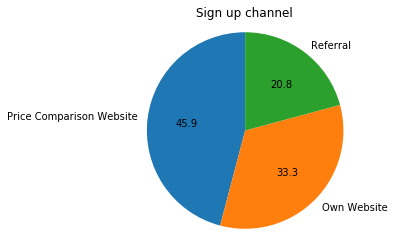

In [143]:
figure, axes = plt.subplots()
three_lab = ("Price Comparison Website", "Own Website", "Referral")

# Draw the pie chart
axes.pie(cust['sign_up_channel'].value_counts(), labels=three_lab, startangle=90, autopct='%1.1f')
axes.axis('equal')

plt.title('Sign up channel')

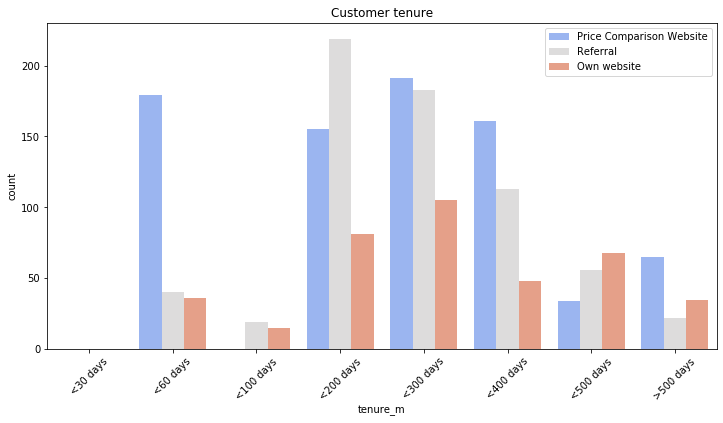

In [152]:
plt.figure(figsize=(12,6))
sb.countplot(data=strat_2, x='tenure_m', hue='sign_up_channel', palette='coolwarm')

lab = ("Price Comparison Website", "Referral", "Own website")
plt.legend(labels=lab)
plt.xticks(rotation=45)
plt.title('Customer tenure')
plt.show()

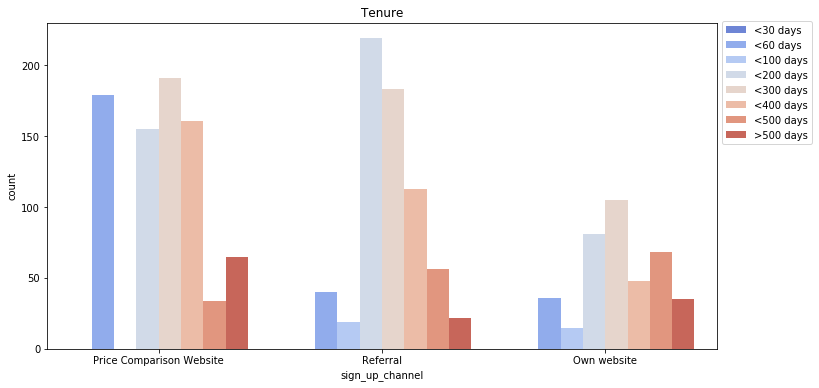

In [150]:
plt.figure(figsize=(12,6))

sb.countplot(data=strat_2, x='sign_up_channel', hue='tenure_m', palette='coolwarm')

plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.xticks(np.arange(3), lab)
plt.title('Tenure')
plt.show()

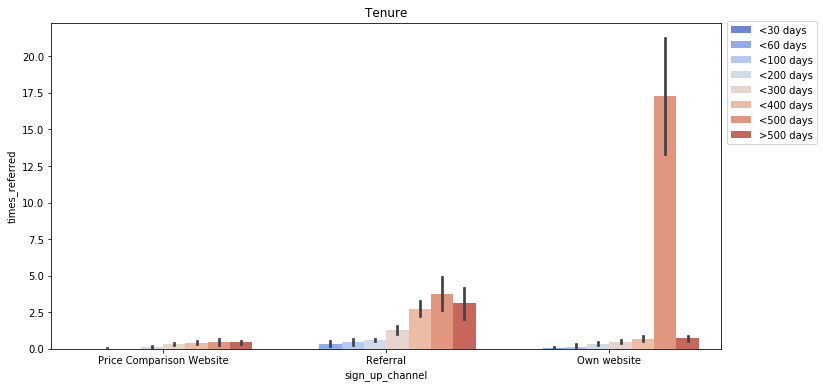

In [155]:
plt.figure(figsize=(12,6))

sb.barplot(data=strat_2, x='sign_up_channel', y='times_referred', hue='tenure_m', palette='coolwarm')

plt.legend(bbox_to_anchor=(1.15, 1.02))
plt.xticks(np.arange(3), lab)
plt.title('Tenure')
plt.show()

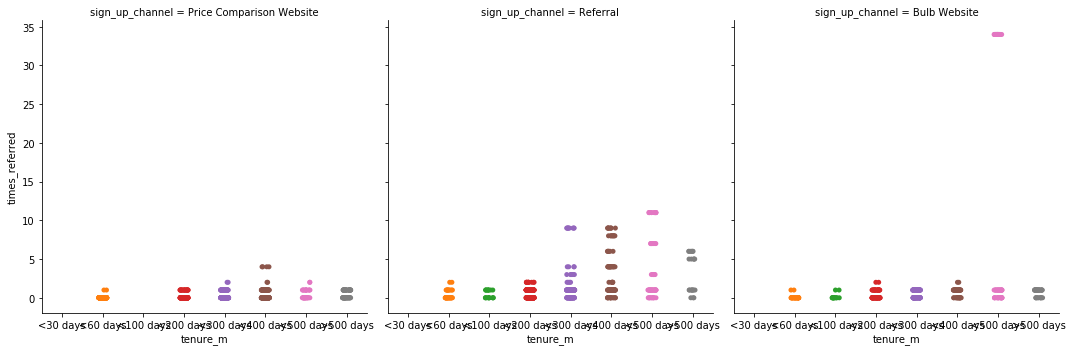

In [169]:
sb.catplot(data=strat_2, x='tenure_m', y='times_referred', col='sign_up_channel')
plt.show()

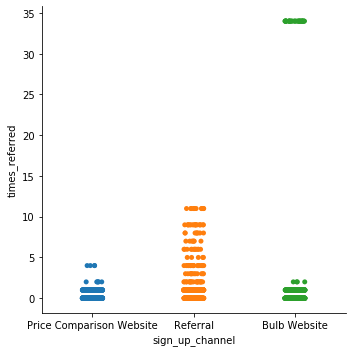

In [171]:
sb.catplot(data=strat_2, y='times_referred', x='sign_up_channel')

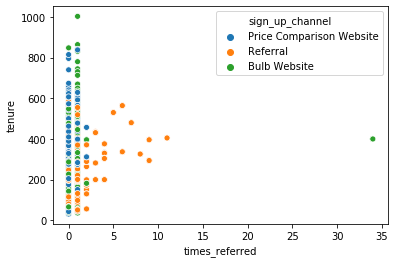

In [172]:
sb.scatterplot(data = strat_2, x='times_referred', y='tenure', hue='sign_up_channel')

### 2.3 Correlation

Chi square test to see if the sign up channel and the referal numbers are truly related.

In [179]:
ordinal_mapping = {
    k: i
    for i, k in enumerate(strat_2['sign_up_channel'].unique(), 1) 
}
strat_2['channel'] = strat_2['sign_up_channel'].map(ordinal_mapping)

In [180]:
strat_2['referred_or_no'] = np.where(strat_2['times_referred'] > 0,1,0)

In [181]:
from scipy.stats import chisquare

In [182]:
sign_up_channel_exp = [33.3, 33.3, 33.3]
sign_up_channel_actual = list(round(strat_2['channel'].value_counts()/ len(strat_2) *100, 1))

In [183]:
chisquare(sign_up_channel_actual, sign_up_channel_exp)

Power_divergenceResult(statistic=7.322822822822824, pvalue=0.02569621918283938)

The above shows that there is about 9% chance we'see this result if the sign up channel was truly random. So sign up channel is affected by something.

Similar conclusion for referal behavior - 0% percent this is a random behavior - something is influencing referring.

Here, I want to test if the mean number of referals across three sign up groups is the same.

In [88]:
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


In [89]:
F, p = stats.f_oneway(strat_2[strat_2['sign_up_channel']=='Price Comparison Website']['sum'],
                      strat_2[strat_2['sign_up_channel']=='Bulb Website']['sum'],
                      strat_2[strat_2['sign_up_channel']=='Referral']['sum'])
print(F, p)


43.44411771695928 3.984736888130811e-19


In [99]:
#plot mean referal count by each group
means = []
for x in strat_2['sign_up_channel'].unique():
    data = strat_2[strat_2['sign_up_channel']==x]
    onemean = round(data['sum'].mean(),1)
    means.append(onemean)
    means
    
means    

In [106]:
strat_2['sign_up_channel'].unique()

array(['Price Comparison Website', 'Bulb Website', 'Referral'],
      dtype=object)

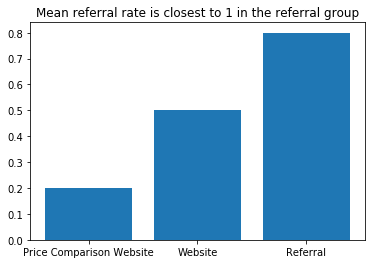

In [113]:
means = {'Price Comparison Website': 0.2, 'Website': 0.5, 'Referral': 0.8}

plt.bar(range(len(means)), means.values(), align='center')
plt.xticks(range(len(means)), list(means.keys()))
plt.title('Mean referral rate is closest to 1 in the referral group')
plt.show()

In [114]:
ols = ols('sum ~ C(sign_up_channel)', data=table_4).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sum   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     43.44
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           3.98e-19
Time:                        18:00:02   Log-Likelihood:                -2548.7
No. Observations:                1697   AIC:                             5103.
Df Residuals:                    1694   BIC:                             5120.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.5467      0.058      9.446      0.000       0.433       0.660
C(sign_up_channel)[T.Price Comparison Website]    -0.3080      0.070     -4.414      0.000      -0.445      -0.171
C(sign_up_channel)[T.Referral]                     0.2479      0.074      3.361      0.001       0.103       0.393
==============================================================================
Omnibus:                     3700.020   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20565983.298
Skew:                          18.760   Prob(JB):                         0.00
Kurtosis:                     541.005   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Overall the model is significiant, F(2,1822)= 60.62, basically zero p-value. This tells us that there is a significant difference in the group means. The coefficients, are the difference in mean between the control group and the respective group listed. The intercept is the mean for the Bulb Wesite group (3.4), Referral group’s coefficient is -1.9, and Price Comparison Website's coefficient is -3.1. Looking at the p-values now (P>|t| in the table), Differences between all sign up groups are significant. There is no comparison between the Referral and the Price Comparison Website group. 

**Answer 2**: Different sign up channels seem to have a relationship with referral behavior.

The first strategy has indicated that most referals in the dataset were done by customers who themselves were refered. In general, people who became customers from Bulb Website are the smallest share of customers, almost equally likely to make a referral as to not make one. 

Customers who signed up from a price comparison websites, who make the majority of customers, are similarly likely to the Bulb Website signups to make a referral. However, these customers in their respective group, are much more likely not to refer anybody. Perhaps, this shows that these are pragmatic customers, who solely care about the price of energy and nothing else. They may also not be aware of the referral scheme, because they do not study Bulb beyond the price.

Finally, the group in the middle, customers who signed up through referrals are more like to make referrals than not. We coudl guess that these customers are the most familiar with the option, because referral was their own access as customers. 

In my second strategy, I conducted the analysis of variance. With a significant F-test score, the results basically tell us that there is a statistically significant difference between each sign up group on the effect they have on the number of referrals made by a customer. The model also gives us an approximate effect of belonging to each group (positive/negative and by how much) on the number of referrals. In particular:
 - Sign up through Bulb Website (increase in referrals by 3.4)
 - Sign up through Price comparison wesite (increase in referals by 0.1)
 - Sign up through Referrals (increase in referals by 1.5)
 

# 3. When/to whom send an email to nudge refering to friends

From looking at the groups of customers who refer the least, it is the price comparison group.

So these should be nudged.

look at the growth rate of referrals...

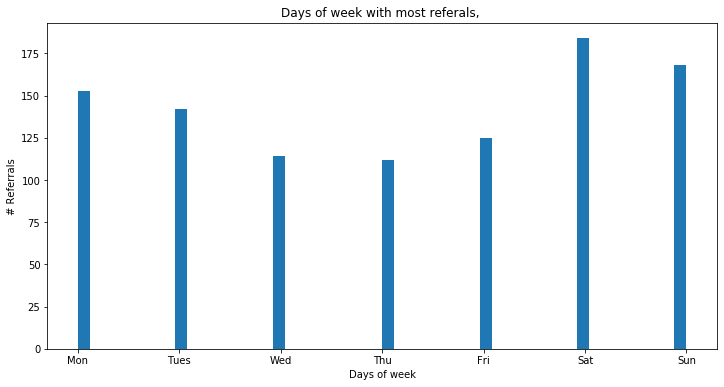

In [119]:
ref['day_week'] = pd.to_datetime(ref['referral_date']).dt.weekday

ref['day_week'].plot(kind='hist', bins=50, figsize=(12,6))
plt.title('Days of week with most referals, ')
plt.xlabel('Days of week')
plt.ylabel('# Referrals')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tues', 'Wed', 
                                                    'Thu', 'Fri', 'Sat', 
                                                    'Sun'])
plt.show()

**Strategy 2**: at what point the number of referrals since signing up starts to decrease.

To implement this strategy, I will plot the number of referals over time since signing up. I will plot this for each group separately.

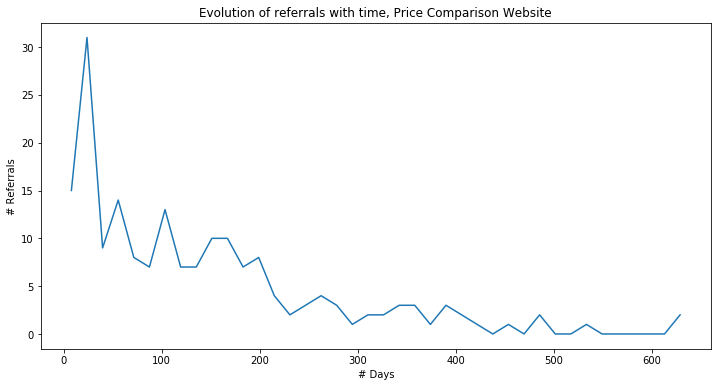

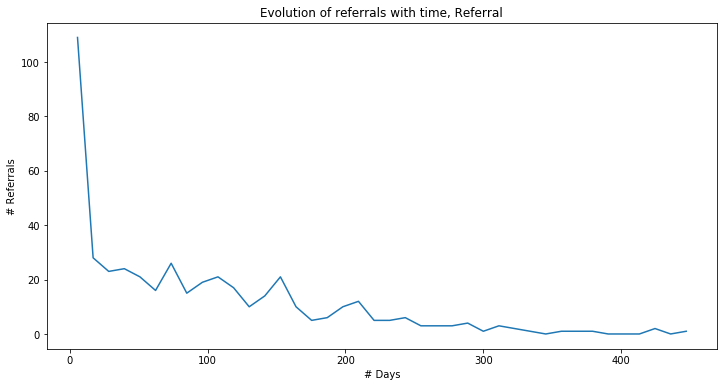

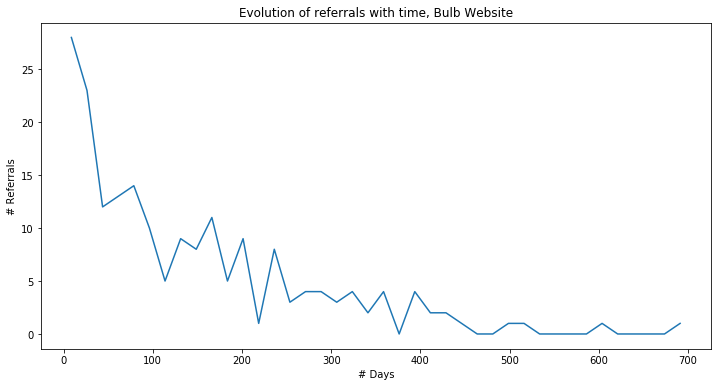

In [400]:
import pylab as p

for i in new_data['sign_up_channel'].unique():
    q3 = new_data[new_data['sign_up_channel']==i]['time_elapsed'].dropna()
    y,binEdges=np.histogram(q3,bins=40)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    plt.figure(figsize=(12,6))
    plt.plot(bincenters,y,'-')
    plt.title('Evolution of referrals with time, '+ i)
    plt.xlabel('# Days')
    plt.ylabel('# Referrals')
    plt.show()
    

**Answer 3**: Similarly as in the previosu question, I used two strategies to answer the question.

Firstly, I investigated referral calendar, by looking at different days of the week by each sign up group, when did most referrals happen. While the graphs give a by group view of the highest "referral-traffic", in general, weekends, in particular Saturdays, are when the customers are most likely to sit down and make a referral.

Then, I looked overtime, how does referral behaviour change in each group. In general, most customers, if they make one, they will make them towards the beginning of their subscription to Bulb services. Overtime, the likelihood that the customer will make a referral drops. There are sly differences, however, in the sharpeness of the drop by each sign up group. Interestingly, the referral sign up group demonstrates the sharpest decrease in their referrals - the soonest after the signup. Other groups are still likely to make referrals slightly (at their own group's referal rate - just because the drop seems to be less steep, other groups still do not make more referrals than the Referral sign up group) longer.

With more time, it would be possible to calculate a universal referal rate and plot it over time for a more accurate comparison between the groups.

# 4. Does the data suggest that the referral behaviour of Bulb members change overtime? What trends are expected and how to measure them?

Overall, yes, the data so far has shown that referrals tend to decrease over time. The reasons can be their own customer experience over time, or generally, signing up to Bulb may seem less exciting after some time to tell your friends about it. 

Depending on what is the preferred way to measure future referrals (number of referrals per customer or the probability of referring), we could construct a basic linear (or a logistic regression - for a probability outcome variable) machine learning algorithm to predict referrals. 

Decision tree or random forest models can also be utilized to make such predictions, depending on how we decide to clasiffy the outcome variable (if we choose a continuous target variable, such as number of referals, and we see that the variable does vary a lot, a classification method would not be a good fit).

More customer data can shed even more light on the analysis of referrals. For example, customer location information (geography, size of communities/neighbourhoods, postal codes) could help distinguishing social networks of customers who can make referrals to one another, allowing to predict growth geographically.

# 5. Are there any other actions you would recommend based on your analysis?

In the previous answers I have listed possible improvements of my current analysis and interpretability that could be achieved with more time. In addition, to cater for consistently updated data, I would rewrite the code in an object-orientated way to make sure it is transferable and easy to run from different devices.

Based on the analysis above, Referral sign up group should be nudged more to make referrals at the beginning of their tenure as customers. Price Comparison Groups could potentially benefit from more information to raise awareness of about the option and benefits of referring. Applicable for all groups, referral nudges could occur as the customers embark closer to a year of being customers. 

Finally, since customers who signed up through Bulb website, have a roughly equal likelihood to refer, it could be a good idea to try to increase customer sign up based through the website as well. This can be done through efforts in increasing website traffic.